In [1]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
from collections import defaultdict
from numpy import hamming
import os
import pickle
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import plot_model

In [2]:
PATH = '../WESAD/'
SUBJECTS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17']
CHEST_SIGNALS = ['ECG', 'EMG', 'EDA', 'Resp', 'Temp', 'ACC']
CHEST_SAMPLING_RATE = 700

In [3]:
def read_subject_data(subject) :
    path = PATH + 'S' + subject + '/S' + subject + '.pkl'
    subject = pd.read_pickle(path)
    
    return subject

In [4]:
def visualize_raw(signal, duration, sampling_rate, title) :
    n = duration * sampling_rate
    l = len(signal)
    
    s = random.randint(0, l - n)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = np.arange(n)
    df['y'] = signal[s:s+n]
    
    plt.figure(figsize=(20, 5))
    sns.scatterplot(x = 'x', y = 'y', data = df, s = 3).set(title=title)

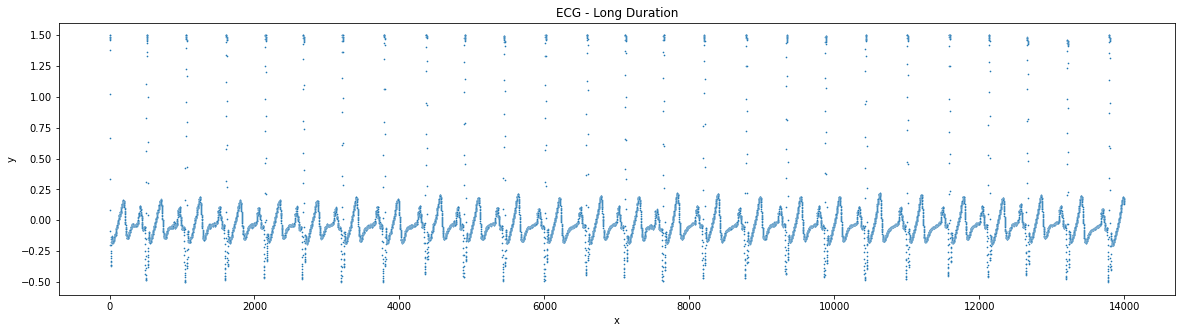

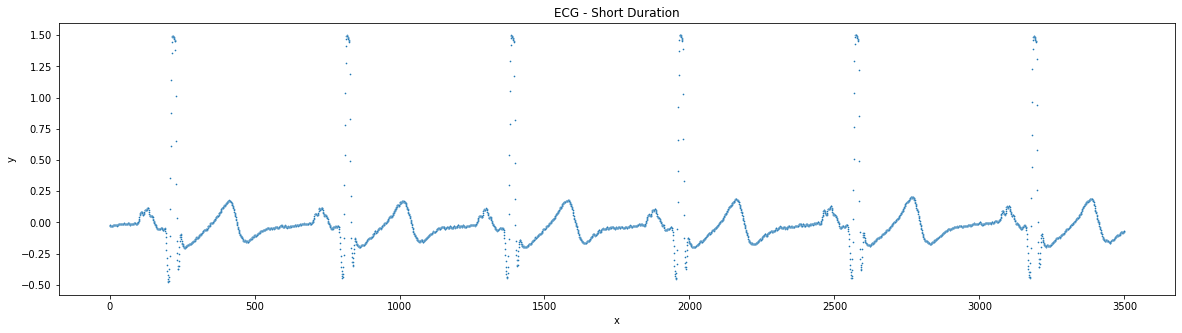

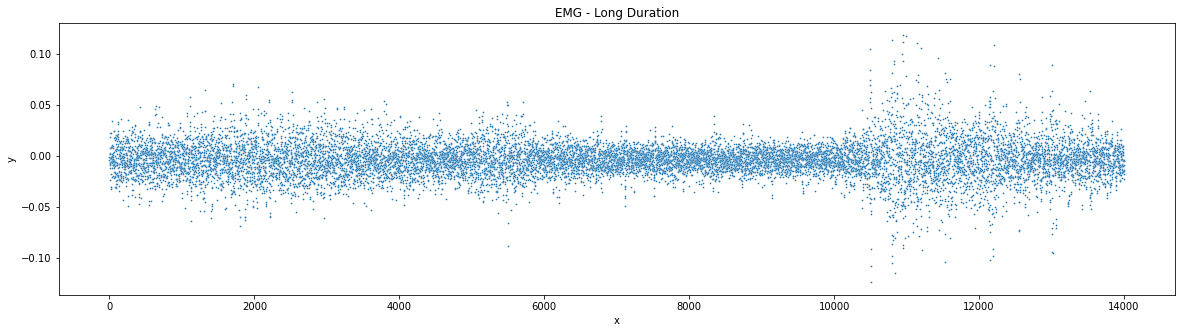

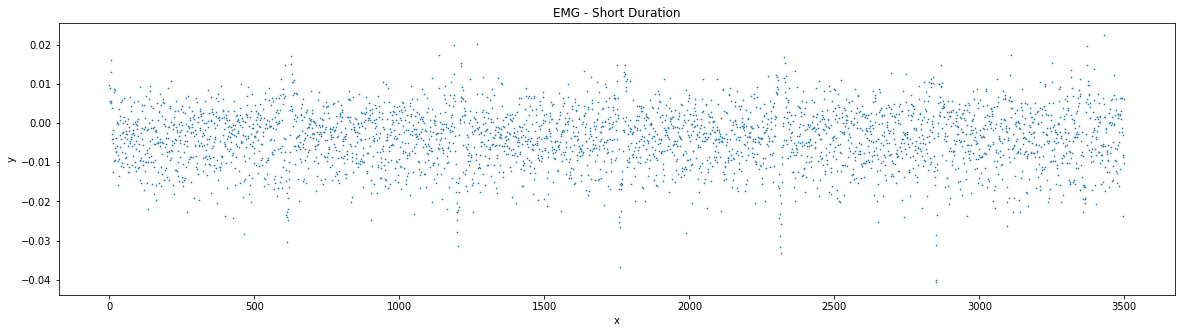

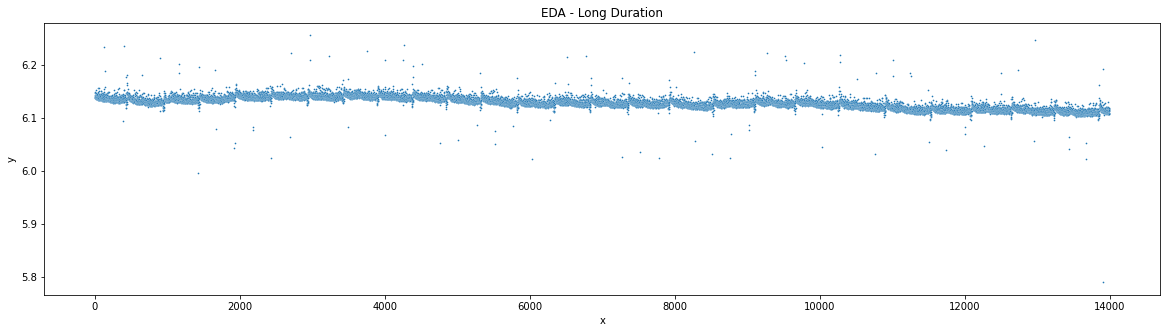

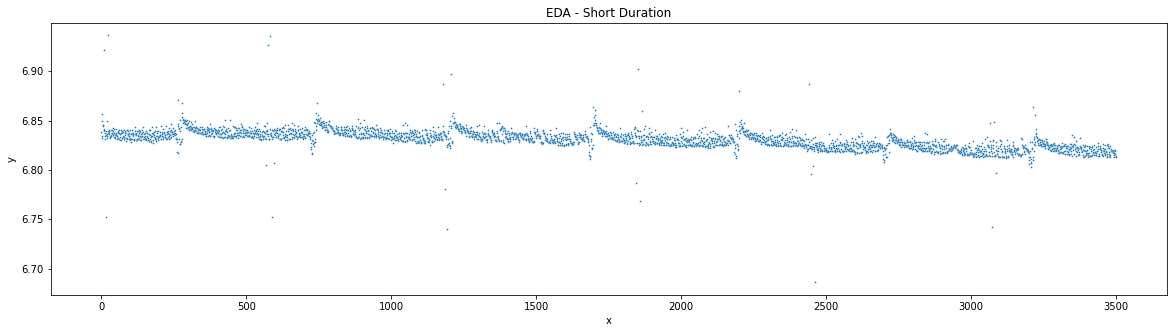

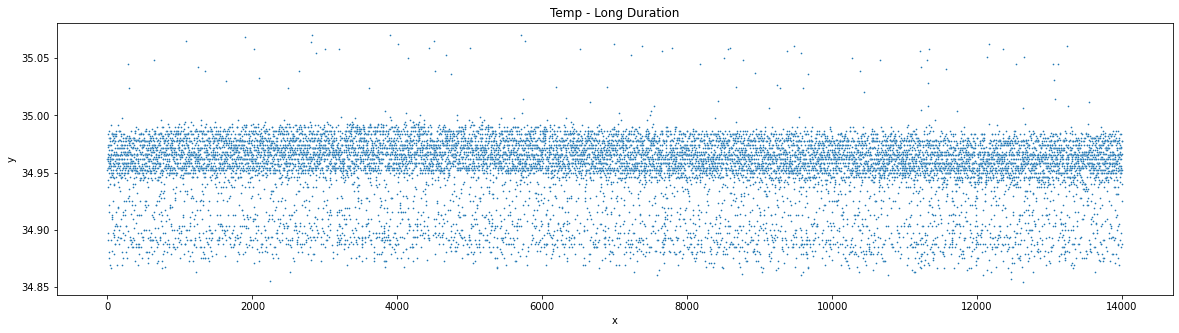

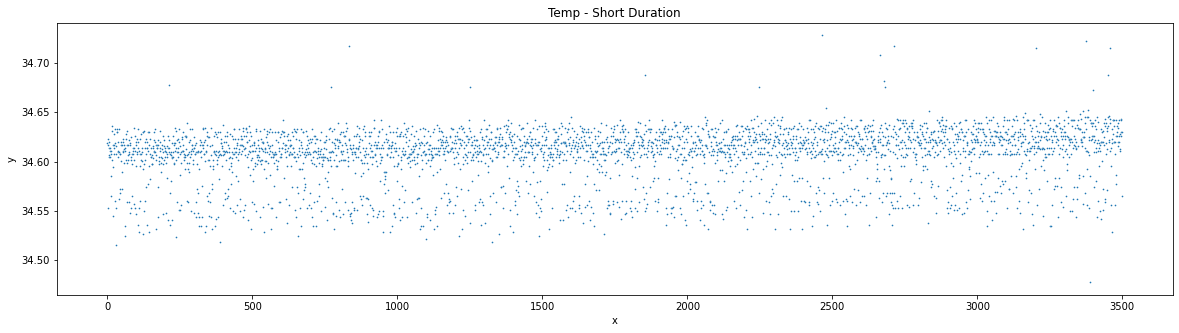

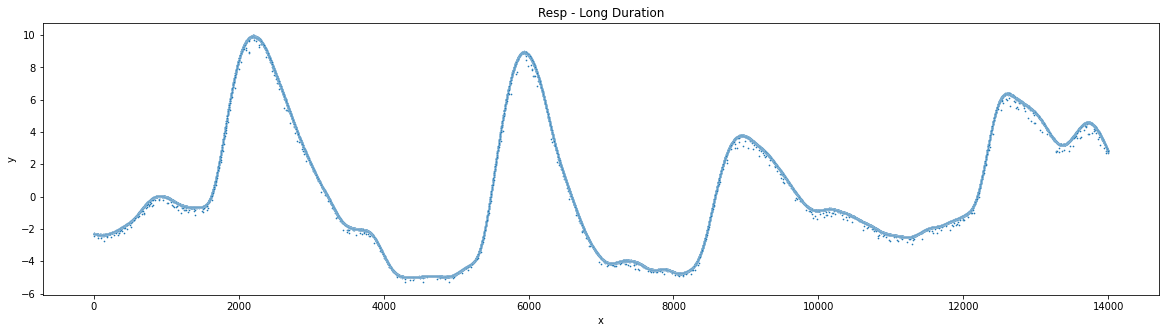

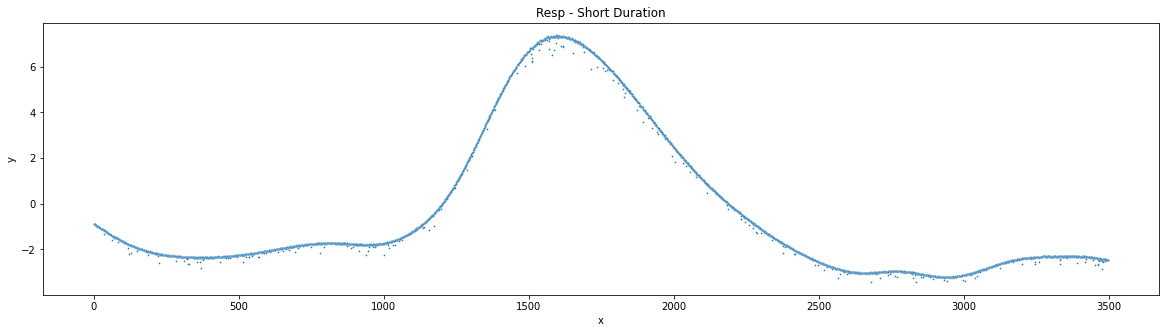

In [5]:
# Visualize the different chest signals for a random subject

SAMPLING_RATE = 700
LONG_DURATION = 20
SHORT_DURATION = 5

subject = random.choice(SUBJECTS)
subject_data = read_subject_data(subject)

chest_signals = subject_data['signal']['chest']

for signal_type in chest_signals :
    if signal_type == 'ACC' :
        continue
    
    signal = chest_signals[signal_type]
    visualize_raw(signal, LONG_DURATION, SAMPLING_RATE, signal_type + ' - Long Duration')
    visualize_raw(signal, SHORT_DURATION, SAMPLING_RATE, signal_type + ' - Short Duration')

In [6]:
# Get additional notes for the Subjects

for subject in SUBJECTS :
    with open(PATH + 'S' + subject + '/S' + subject + '_readme.txt', 'r') as file :
        print(subject, file.readlines()[16])

2 The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.

3 During the baseline condition, the subject was sitting in a sunny workplace.

4 -

5 Subject might have fallen asleep during the first meditation.

6 Subject claimed that he had a stressfull week and hence the study was rather relaxing for him.

7 -

8 Subject had already a rather stressful day, prior to the study.

9 -

10 -

11 -

13 -

14 -

15 Subject didn't really believe the cover story of the stress condition (TSST).

16 Subject felt rather cold in the room where the stress condition was carried out.

17 The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.



In [96]:
# https://imotions.com/blog/eda/
# https://www.scitepress.org/Papers/2021/102446/102446.pdf
# https://sci-hub.ee/10.1016/j.cmpb.2020.105482
WINDOW_LEN = 30
OVERLAP = 0.9
NUM_FEATURES = 10
EPOCH = 128
BATCH_SIZE=48

In [97]:
# Identify the continuous intervals for each label
def find_intervals(labels) :
    intervals = []

    l = len(labels)
    i = 0
    label = labels[0]

    for j in range(l):
        if label != labels[j]:
            intervals.append({
                'label' : label, 
                'beg' : i,
                'end' : j
                })
            i = j
            label = labels[j]

    intervals.append({
        'label' : label, 
        'beg' : i,
        'end' : l
    })

    return intervals    

In [98]:
def to_consider(last_feature, current_feature, feature_std) :
    diff = abs(last_feature - current_feature)
    
    if diff > 0.1*feature_std :
        return True
    
    return False

In [99]:
def extract_fft_features(signal, num_features) :
    window = hamming(len(signal))
    signal *= window
    coeffs = fft.fft(signal)
    l = len(coeffs)
    freqs = fft.fftfreq(l)
    
    # Discard the negative elems
    l //= 2
    amps = np.abs(coeffs[0:l])
    freqs = np.abs(freqs[0:l])
    
    # Sort descending w.r.t amp   
    p = amps.argsort()[::-1]
    freqs = freqs[p]
    amps = amps[p]
    
    amps_std = np.std(amps)
    freqs_std = np.std(freqs)
    
    features = [[amps[0], freqs[0]]]
    
    i = 1
    while num_features > 1 :
        if to_consider(features[-1][0], amps[i], amps_std) :
            features.append([amps[i], freqs[i]])
            num_features -= 1
        elif to_consider(features[-1][1], freqs[i], freqs_std) :
            features.append([amps[i], freqs[i]])
            num_features -= 1
            
        i += 1
    
#     features = [[amps[i], freqs[i]] for i in range(num_features)]   
    return np.array(features)

In [100]:
def normalize_fft_features(train_features, test_features) :
    feature_mean = np.mean(train_features, axis=0)
    print(np.shape(feature_mean))
    feature_std = np.std(train_features, axis=0)
    train_features -= feature_mean
    test_features -= feature_mean
    train_features = np.divide(train_features, feature_std, out=np.zeros_like(train_features), where=feature_std!=0)
    test_features = np.divide(test_features, feature_std, out=np.zeros_like(test_features), where=feature_std!=0)
    
    return train_features, test_features

In [101]:
TRANSIENT = 0
BASELINE = 1
STRESS = 2
AMUSEMENT = 3
MEDITATION = 4
IGNORE = 5

def extract_signal_features(signal, intervals, sampling_rate, window_len = WINDOW_LEN, overlap = OVERLAP, num_features = NUM_FEATURES) :
    segment_size = sampling_rate * window_len
    signal_features = {
        BASELINE : [],
        STRESS : [],
        AMUSEMENT : [],
        MEDITATION : []
    }
    
    baseline_av = 0
    
    for interval in intervals :
        label = interval['label']
        beg = interval['beg']
        end = interval['end']
        
        signal_of_interest = signal[beg:end]  
        
        if label >= IGNORE or label == TRANSIENT:
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
            continue      
            
        if label == BASELINE :
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
        
        signal_of_interest -= baseline_av
        
        l = end - beg        
        while l >= segment_size:
            segment = signal_of_interest[int(l - segment_size) : l]
            l -= int((1 - overlap) * segment_size)
            
            segment_features = extract_fft_features(segment, num_features)            
            signal_features[label].append(segment_features)
        
    return signal_features

In [1]:
# Get Joint test-train  Datasets combining all signals

def get_chest_signal_dataset(subjects, signal_types = CHEST_SIGNALS) :
    combined_subject_features = {}
    
    for subject in subjects :
        subject_data = read_subject_data(subject)
        intervals = find_intervals(subject_data['label'])
        
        subject_features = {
            BASELINE : [],
            STRESS : [],
            AMUSEMENT : [],
            MEDITATION : []
        }
        
        for signal_type in signal_types :
            if signal_type == 'ACC' :
                continue
                
            signal = np.array(subject_data['signal']['chest'][signal_type]).flatten()
            signal_features = extract_signal_features(signal, intervals, CHEST_SAMPLING_RATE)
            
            for label, features in signal_features.items() :
                subject_features[label].append(features)
                
        for label in subject_features :
            subject_features[label] = np.stack(subject_features[label], axis = -1)
            
        aggregate_subject_features = []
        aggregate_subject_labels = []
            
        for label, features in subject_features.items() :
            for feature in features :
                aggregate_subject_features.append(feature)
                aggregate_subject_labels.append(label)
                
        feature_mean = np.mean(aggregate_subject_features, axis=0)
        feature_std = np.std(aggregate_subject_features, axis=0)
        
        aggregate_subject_features = np.array(aggregate_subject_features) - feature_mean
        aggregate_subject_features = np.divide(aggregate_subject_features, feature_std, out=np.zeros_like(aggregate_subject_features), where=feature_std!=0)
                
        combined_subject_features[subject] = {
            'features' : aggregate_subject_features,
            'labels' : aggregate_subject_labels
        }

    return combined_subject_features

NameError: name 'CHEST_SIGNALS' is not defined

In [2]:
def generate_dataset(combined_subject_features, subjects) :
    features_dataset = []
    labels_dataset = []
    
    for subject in subjects :
        features_dataset += list(combined_subject_features[subject]['features'])
        labels_dataset += combined_subject_features[subject]['labels']
        
    return np.array(features_dataset), np.array(labels_dataset)

In [3]:
def encode_labels(labels) :
    encoder = {
        1 : [1, 0, 0, 0],
        2 : [0, 1, 0, 0],
        3 : [0, 0, 1, 0],
        4 : [0, 0, 0, 1]
    }
    
    return np.array([np.array(encoder[l]) for l in labels])

In [4]:
def get_confusion_matrix(model, test_features, test_labels) :
    predicted_labels = model.predict(test_features)

    confusion_matrix = np.zeros((4, 4))
    accuracy = 0
    for test_label, predicted_label in zip(test_labels, predicted_labels) :
        i = np.argmax(test_label)
        j = np.argmax(predicted_label)

        confusion_matrix[i][j] += 1
        
        if (i == j) :
            accuracy += 1.0
        
    confusion_matrix /= np.sum(confusion_matrix, axis=1).reshape(4, 1)
    
    return confusion_matrix, accuracy/len(test_labels)

In [5]:
combined_subject_features = get_chest_signal_dataset(SUBJECTS)

NameError: name 'get_chest_signal_dataset' is not defined

In [6]:
def get_class_weights(train_labels) :
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    print(class_weights)
    return dict(enumerate(class_weights))

In [108]:
init_weights = '../Models/init_weights.hdf5'
best_model = '../Models/best_model.hdf5'

In [109]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10, 2, 5)),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish', depth_multiplier=2),
#     keras.layers.Dropout(0.2),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish', depth_multiplier=2),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish', depth_multiplier=2),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
#     keras.layers.SpatialDropout2D(0.1),
    keras.layers.Conv2D(20, kernel_size=(1, 1), activation='swish'),
    keras.layers.Conv2D(10, kernel_size=(1, 1), activation='swish'),
    keras.layers.Conv2D(8, kernel_size=(2,1), activation='swish'),
    keras.layers.Conv2D(8, kernel_size=(1,2), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(2,1), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=6,  activation='swish'),
    keras.layers.Dense(units=4, activation='swish')
])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d_50 (Depthwi (None, 9, 2, 10)          30        
_________________________________________________________________
depthwise_conv2d_51 (Depthwi (None, 8, 2, 20)          60        
_________________________________________________________________
depthwise_conv2d_52 (Depthwi (None, 7, 2, 40)          120       
_________________________________________________________________
depthwise_conv2d_53 (Depthwi (None, 5, 2, 40)          160       
_________________________________________________________________
depthwise_conv2d_54 (Depthwi (None, 3, 2, 40)          160       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 3, 2, 20)          820       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 3, 2, 10)        

In [77]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10, 2, 5)),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish', depth_multiplier=2),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish', depth_multiplier=2),
#     keras.layers.Dropout(0.2),
#     keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish'),
#     keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish'),
#     keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
#     keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.Conv2D(10, kernel_size=(2,1), activation='swish'),
    keras.layers.Conv2D(10, kernel_size=(2,1), activation='swish'),
    keras.layers.SpatialDropout2D(0.1),
    keras.layers.Conv2D(10, kernel_size=(1,2), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=10,  activation='swish'),
    keras.layers.Dense(units=8,  activation='swish'),
    keras.layers.Dense(units=4, activation='swish')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d_33 (Depthwi (None, 9, 2, 10)          30        
_________________________________________________________________
depthwise_conv2d_34 (Depthwi (None, 8, 2, 20)          60        
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 2, 10)          410       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 6, 2, 10)          210       
_________________________________________________________________
spatial_dropout2d_13 (Spatia (None, 6, 2, 10)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 6, 1, 10)          210       
_________________________________________________________________
flatten_11 (Flatten)         (None, 60)              

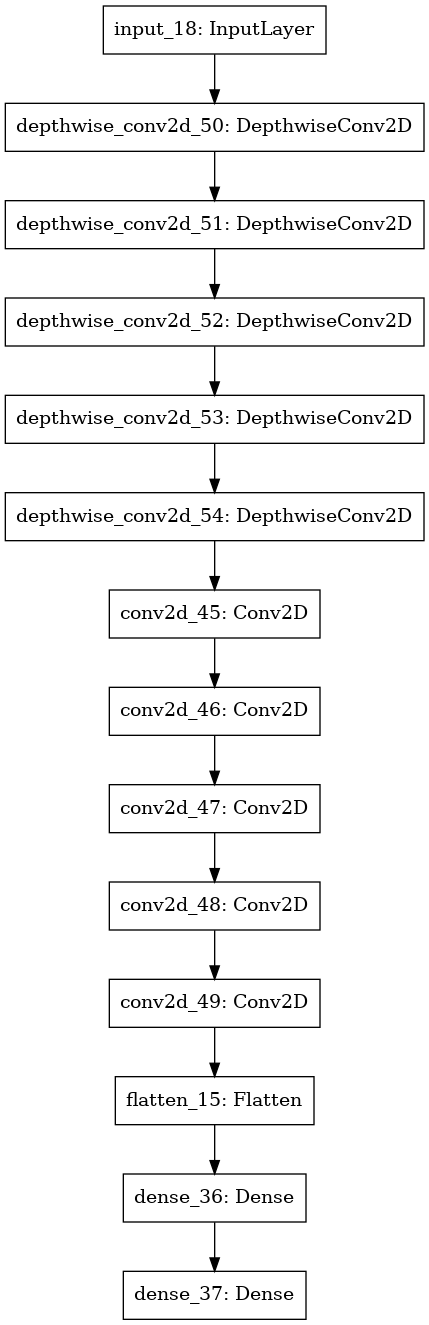

In [110]:
plot_model(model, to_file='model.png')

In [111]:
model.save_weights(init_weights)

In [112]:
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [113]:
subject_conf_matrix = {}

for i in range(len(SUBJECTS)) :
    test_subject = SUBJECTS[i]
    train_subjects = SUBJECTS[:i] + SUBJECTS[i+1:]
    
    train_features, train_labels = generate_dataset(combined_subject_features, train_subjects)
    test_features, test_labels = generate_dataset(combined_subject_features, [test_subject])
    
    class_weights = get_class_weights(train_labels)
    
    train_labels = encode_labels(train_labels)
    test_labels = encode_labels(test_labels)
      
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=best_model,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=EPOCH,
        restore_best_weights=True,
        verbose=1
    )

    model.load_weights(init_weights)

    model.fit(
        train_features, train_labels, 
        epochs=EPOCH, batch_size = BATCH_SIZE, 
        verbose=1, shuffle=True, 
        class_weight=class_weights, 
        validation_data=(test_features,  test_labels),
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    
#     model.load_weights(best_model)
    
    subject_conf_matrix[test_subject], accuracy = get_confusion_matrix(model, test_features, test_labels)  
    print('-------------', test_subject,'-------------')
    print('row - actual, col - predicted')
    print(subject_conf_matrix[test_subject])
    print(accuracy)

    with open("../ExtraData/confusion_matrix.pkl", 'wb') as file :
        pickle.dump(subject_conf_matrix, file)

[0.62388018 1.11947421 2.07753263 0.9779842 ]
Epoch 1/128
279/279 [==============================] - 1s 3ms/step - loss: 1.3844 - accuracy: 0.1974 - val_loss: 1.3281 - val_accuracy: 0.5775

Epoch 00001: val_accuracy improved from -inf to 0.57751, saving model to ../Models/best_model.hdf5
Epoch 2/128
279/279 [==============================] - 1s 2ms/step - loss: 0.9368 - accuracy: 0.7397 - val_loss: 1.0010 - val_accuracy: 0.6638

Epoch 00002: val_accuracy improved from 0.57751 to 0.66376, saving model to ../Models/best_model.hdf5
Epoch 3/128
279/279 [==============================] - 1s 2ms/step - loss: 0.7382 - accuracy: 0.8077 - val_loss: 0.5615 - val_accuracy: 0.7806

Epoch 00003: val_accuracy improved from 0.66376 to 0.78057, saving model to ../Models/best_model.hdf5
Epoch 4/128
279/279 [==============================] - 1s 2ms/step - loss: 0.6054 - accuracy: 0.8262 - val_loss: 0.5058 - val_accuracy: 0.7467

Epoch 00004: val_accuracy did not improve from 0.78057
Epoch 5/128
279/279 


Epoch 00039: val_accuracy did not improve from 0.93231
Epoch 40/128
279/279 [==============================] - 1s 3ms/step - loss: 0.1694 - accuracy: 0.9539 - val_loss: 1.6119 - val_accuracy: 0.8221

Epoch 00040: val_accuracy did not improve from 0.93231
Epoch 41/128
279/279 [==============================] - 1s 3ms/step - loss: 0.1661 - accuracy: 0.9545 - val_loss: 1.8183 - val_accuracy: 0.8024

Epoch 00041: val_accuracy did not improve from 0.93231
Epoch 42/128
279/279 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.9554 - val_loss: 1.8449 - val_accuracy: 0.8079

Epoch 00042: val_accuracy did not improve from 0.93231
Epoch 43/128
279/279 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.9569 - val_loss: 1.5480 - val_accuracy: 0.8231

Epoch 00043: val_accuracy did not improve from 0.93231
Epoch 44/128
279/279 [==============================] - 1s 3ms/step - loss: 0.1614 - accuracy: 0.9559 - val_loss: 1.3407 - val_accuracy: 0.8286



Epoch 00080: val_accuracy did not improve from 0.93231
Epoch 81/128
279/279 [==============================] - 1s 3ms/step - loss: 0.1172 - accuracy: 0.9677 - val_loss: 2.0596 - val_accuracy: 0.7795

Epoch 00081: val_accuracy did not improve from 0.93231
Epoch 82/128
279/279 [==============================] - 1s 3ms/step - loss: 0.1192 - accuracy: 0.9687 - val_loss: 1.2878 - val_accuracy: 0.8417

Epoch 00082: val_accuracy did not improve from 0.93231
Epoch 83/128
279/279 [==============================] - 1s 3ms/step - loss: 0.1157 - accuracy: 0.9673 - val_loss: 0.7865 - val_accuracy: 0.8755

Epoch 00083: val_accuracy did not improve from 0.93231
Epoch 84/128
279/279 [==============================] - 1s 3ms/step - loss: 0.1104 - accuracy: 0.9693 - val_loss: 2.1803 - val_accuracy: 0.7860

Epoch 00084: val_accuracy did not improve from 0.93231
Epoch 85/128
279/279 [==============================] - 1s 3ms/step - loss: 0.1135 - accuracy: 0.9687 - val_loss: 1.9561 - val_accuracy: 0.8253



Epoch 00121: val_accuracy did not improve from 0.93231
Epoch 122/128
279/279 [==============================] - 1s 3ms/step - loss: 0.0817 - accuracy: 0.9768 - val_loss: 1.9154 - val_accuracy: 0.8483

Epoch 00122: val_accuracy did not improve from 0.93231
Epoch 123/128
279/279 [==============================] - 1s 3ms/step - loss: 0.0768 - accuracy: 0.9768 - val_loss: 1.6835 - val_accuracy: 0.8592

Epoch 00123: val_accuracy did not improve from 0.93231
Epoch 124/128
279/279 [==============================] - 1s 3ms/step - loss: 0.0826 - accuracy: 0.9758 - val_loss: 1.8845 - val_accuracy: 0.8570

Epoch 00124: val_accuracy did not improve from 0.93231
Epoch 125/128
279/279 [==============================] - 1s 3ms/step - loss: 0.0795 - accuracy: 0.9775 - val_loss: 1.7975 - val_accuracy: 0.8373

Epoch 00125: val_accuracy did not improve from 0.93231
Epoch 126/128
279/279 [==============================] - 1s 3ms/step - loss: 0.0754 - accuracy: 0.9774 - val_loss: 1.6734 - val_accuracy: 0.

KeyboardInterrupt: 